# BERT 模型在气候风险评估上的实践

## 1. 引言

气候变化对社会、经济和环境的影响广受关注，而准确评估相关术语的风险和正面影响至关重要。例如，“碳税”（carbon tax）、“可再生能源”（renewable energy）和“洪水”（flood）等关键词在不同语境下可能具有不同的风险等级和正面价值。传统方法主要依赖专家判断或统计分析，难以高效处理大规模文本数据并捕捉复杂语义关系。

近年来，基于 Transformer 的预训练语言模型（如 BERT）在文本理解和多标签任务中表现优异。然而，在气候变化研究中，NLP 技术的应用仍较有限，特别是在关键词风险与正面影响评估方面。

本研究利用 BERT 模型对 25 个气候变化相关关键词进行风险和正面评分，并探索其在政策制定、风险管理和公众沟通中的潜在价值。研究创新点包括：（1）首次将 BERT 应用于该任务；（2）设计同时预测风险与正面分数的训练方法；（3）通过误差分析和可视化评估模型表现。

本文结构如下：第 2 节介绍数据准备与预处理，第 3 节描述模型训练与评估，第 4 节展示实验结果，第 5 节讨论模型局限性，第 6 节总结研究发现并展望未来工作。

### 1.1 量化气候变化

本文通过 气候风险维度（risk score）和 气候积极性维度（positive score）对气候变化相关术语进行量化评估，以便更好地理解不同关键词在政策、风险管理和社会认知中的作用。

#### A) 气候风险维度

该维度衡量某个词汇在气候变化相关语境下的潜在负面影响或风险程度。

- 高风险词汇（得分 8-10）：与自然灾害、极端天气事件或政策不确定性相关的词汇，例如 "flood", "hurricane", "policy uncertainty"。这类风险可能带来较大社会经济损失。
- 中等风险词汇（得分 5-7）：与排放或监管相关的词汇，例如 "carbon emission", "climate regulation"，这类风险反映政策和市场的调控力度。
- 低风险词汇（得分 0-4）：与积极行动或技术相关的词汇，例如 "renewable energy", "emission reduction target"。这类风险对环境影响较小甚至有助于减少风险。

#### B) 气候积极性维度
该维度衡量某个词汇在应对气候变化方面的正面贡献或积极性。
- 高积极性词汇（得分 8-10）：与减排、可再生能源或适应措施相关的词汇，例如 "renewable energy", "emission reduction target", "climate adaptation"。这类词汇代表了气候政策和可持续发展的核心。
- 中等积极性词汇（得分 5-7）：与技术或政策工具相关的词汇，例如 "low-carbon technology", "carbon pricing"。
- 低积极性词汇（得分 0-4）：与风险或问题相关的词汇，例如 "flood", "hurricane"。

未来，可结合专家意见对评分体系进行调整，以提高评估的准确性和适用性。

In [1]:
risk_scores = {
    "flood": 10, "hurricane": 10, "drought": 10, "extreme heat": 9,
    "storm": 9, "policy uncertainty": 8, "carbon emission": 7,
    "greenhouse gas": 7, "emission intensity": 6, "carbon dioxide": 6, 
    "climate regulation": 6, "carbon tax": 5, "emission trading": 5,
    "carbon pricing": 5,"emission reduction target": 4,
    "climate resilience": 3, "infrastructure upgrade": 3, 
    "emergency plan": 3, "climate adaptation": 3, "adaptation plan": 3, 
    "renewable energy": 2, "solar power": 2, "wind power": 2,
    "low-carbon technology": 2, "energy transition": 2
}

positive_scores = {
    "renewable energy": 10, "solar power": 10, "wind power": 10,
    "low-carbon technology": 9, "energy transition": 9,
    "emission reduction target": 9, "climate adaptation": 8, 
    "adaptation plan": 8, "climate resilience": 8,
    "infrastructure upgrade": 8, "emergency plan": 8,
    "carbon tax": 7, "emission trading": 7, "carbon pricing": 7,
    "climate regulation": 6, "carbon emission": 4, "greenhouse gas": 4,
    "emission intensity": 3, "carbon dioxide": 3, "flood": 2, "hurricane": 2,
    "drought": 2, "extreme heat": 2, "storm": 2, "policy uncertainty": 1
}

In [2]:
keywords = list(risk_scores.keys()) 

## 2. 数据准备与预处理

### 2.1 创建数据集

首先，创建一个包含关键词、风险评分（risk_label）和正面评分（positive_label）的数据集，并将分数归一化到 0-1 之间（除以 10）。然后，它使用 Dataset.from_dict() 将数据转换为 Hugging Face datasets 库支持的数据集格式，以便用于后续的模型训练或分析。

In [3]:
from datasets import Dataset
import numpy as np

# 创建数据集， 
data = {
    "text": keywords,
    "risk_label": [risk_scores.get(kw, 0) / 10.0 for kw in keywords],  
    "positive_label": [positive_scores.get(kw, 0) / 10.0 for kw in keywords]
}
dataset = Dataset.from_dict(data)


### 2.2 加载预训练模型和分词器

接着，加载预训练的 BERT 模型（bert-base-uncased），并将其配置为双标签分类任务（num_labels=2，用于预测风险分数和正面分数）。同时，它还加载了对应的 BERT 分词器（AutoTokenizer），用于将文本转换为模型可接受的输入格式。

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.3 数据预处理函数

接着，定义一个预处理函数 preprocess_function，用于将文本数据进行编码，处理为固定长度的输入，并将风险标签和正向标签组合成一个新的标签字段返回。

In [5]:
def preprocess_function(examples):
    encodings = tokenizer(examples["text"], truncation=True,
                          padding="max_length", max_length=128)
    encodings["labels"] = np.array(list(zip(examples["risk_label"],
                                            examples["positive_label"])),
                                   dtype=np.float32)
    return encodings

### 2.4 对数据集进行编码

接下来，使用 map 方法对数据集进行批量预处理，调用 preprocess_function 来处理每条数据；接着移除原始的文本和标签列，最后将数据集按照80%训练集和20%测试集的比例进行拆分。

In [6]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [7]:
encoded_dataset = encoded_dataset.remove_columns(["text", "risk_label",
                                                  "positive_label"])

In [8]:
encoded_dataset = encoded_dataset.train_test_split(test_size=0.2)

### 2.5 自定义 Trainer 来处理两个标签（风险和正面分数）

然后，定义一个自定义的训练器 CustomTrainer，它通过重写计算损失的方式来优化模型训练。具体来说，它计算模型的预测结果与实际标签之间的差距（使用均方误差MSE），并返回损失值用于训练。

In [9]:
from transformers import TrainingArguments, Trainer
import torch

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        if isinstance(labels, np.ndarray):  # 兼容 NumPy 格式
            labels = torch.tensor(labels, dtype=torch.float32).to(model.device)

        model_inputs = {k: v for k, v in inputs.items() if k != "labels"}
        outputs = model(**model_inputs)
        logits = outputs.logits
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

## 3. 模型训练与评估

### 3.1 定义评估指标

然后，设计函数计算模型预测值与真实标签之间的均方误差（MSE），并返回一个包含 MSE 的字典。

In [10]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, tuple):  # 兼容不同 Trainer 版本
        predictions = predictions[0]

    mse = np.mean((predictions - labels) ** 2)
    return {"mse": mse}

### 3.2 设置训练参数

再然后，定义训练参数 training_args，设置输出目录、评估策略、学习率、批次大小、训练轮数、权重衰减、日志记录和保存策略等训练配置。具体而言，它将在每个训练周期进行评估和保存，并每10步记录一次日志。

In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
)

### 3.3 初始化 Trainer

这段代码创建了一个 CustomTrainer 实例，传入了模型、训练参数、训练集、测试集和计算评估指标的函数，用于训练和评估模型。

In [12]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics,
)

### 3.4 训练模型

In [13]:
trainer.train()
trainer.save_model("./trained_model")

Epoch,Training Loss,Validation Loss,Mse
1,No log,0.314457,0.314457
2,No log,0.150936,0.150936
3,No log,0.083095,0.083095
4,0.256200,0.084059,0.084059
5,0.256200,0.070650,0.070650
6,0.256200,0.073462,0.073462
7,0.084900,0.061905,0.061905
8,0.084900,0.030397,0.030397
9,0.084900,0.036832,0.036832
10,0.045900,0.030561,0.030561


表1：模型训练过程中的损失和评估指标

该表展示了模型在20个epoch训练过程中的训练损失（Training Loss）、验证损失（Validation Loss）和均方误差（MSE）。可以看出，验证损失在第16个epoch时达到最低值0.015627，表明模型在此时表现最佳。

## 4. 实验结果与分析

### 4.1 预测新文本的函数

设计函数 predict_scores 对输入文本进行编码并传入模型进行预测，获取模型输出的 logits，并返回风险评分和正向评分。

In [14]:
def predict_scores(text, model, tokenizer):
    # 对输入文本进行编码
    inputs = tokenizer(text, return_tensors="pt", truncation=True,
                       padding="max_length", max_length=128)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    # 进行预测
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # 获取模型输出的 logits
    
    # 确保 logits 形状正确
    if logits.shape[-1] != 2:
        raise ValueError(f"Expected 2 output values (risk, positive),
                            but got {logits.shape[-1]}")
    
    risk_score, positive_score = logits[0].cpu().numpy()  # 转换为 NumPy 数组
    
    return float(risk_score), float(positive_score)  # 确保返回的是 Python 数值类型

### 4.2 单个关键词的测试与验证

对文本 “flood” 进行预测，输出预测的风险评分和正向评分，并与预期的评分进行对比。

In [15]:
text = "flood"
risk_score, positive_score = predict_scores(text, model, tokenizer)
print(f"Text: {text}")
print(f"Predicted Risk Score: {risk_score * 10:.2f} 
            (Expected: {risk_scores[text]})")
print(f"Predicted Positive Score: {positive_score * 10:.2f}
            (Expected: {positive_scores[text]})")

Text: flood
Predicted Risk Score: 9.06 (Expected: 10)
Predicted Positive Score: 1.24 (Expected: 2)


### 4.3 预测值与真实值的误差

设计3个函数包含三个主要功能：1) get_all_predictions 用于获取所有关键词的预测值并记录真实值；2) compute_errors 计算实际值与预测值之间的误差；3) plot_results 可视化预测结果，包括实际值与预测值的散点图以及误差分布的直方图。

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. 计算所有关键词的预测值
def get_all_predictions(keywords, model, tokenizer):
    predicted_risk_scores = []
    predicted_positive_scores = []
    actual_risk_scores = []
    actual_positive_scores = []

    for keyword in tqdm(keywords, desc="Predicting"):
        risk_pred, positive_pred = predict_scores(keyword, model, tokenizer)

        # 记录真实值
        actual_risk_scores.append(risk_scores[keyword])
        actual_positive_scores.append(positive_scores[keyword])

        # 记录预测值（如果有归一化，则要 * 10）
        predicted_risk_scores.append(risk_pred * 10)
        predicted_positive_scores.append(positive_pred * 10)

    return actual_risk_scores, predicted_risk_scores,
            actual_positive_scores, predicted_positive_scores


# 2. 计算误差
def compute_errors(actual, predicted):
    errors = np.array(predicted) - np.array(actual)  # 计算误差
    return errors


# 3. 可视化
def plot_results(actual, predicted, score_type="Risk Score"):
    plt.figure(figsize=(12, 5))

    # 真实值 vs 预测值（散点图）
    plt.subplot(1, 2, 1)
    plt.scatter(actual, predicted, alpha=0.7, color="blue")
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)],
             "--", color="red", label="Ideal Prediction")  # 理想预测线
    plt.xlabel(f"Actual {score_type}")
    plt.ylabel(f"Predicted {score_type}")
    plt.title(f"Actual vs. Predicted {score_type}")
    plt.legend()

    # 误差分布（直方图）
    plt.subplot(1, 2, 2)
    errors = compute_errors(actual, predicted)
    sns.histplot(errors, bins=20, kde=True, color="purple")
    plt.axvline(x=0, color="red", linestyle="--", label="Zero Error")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title(f"Error Distribution ({score_type})")
    plt.legend()
    plt.tight_layout()
    plt.show()


Predicting: 100%|██████████| 25/25 [00:00<00:00, 64.27it/s]


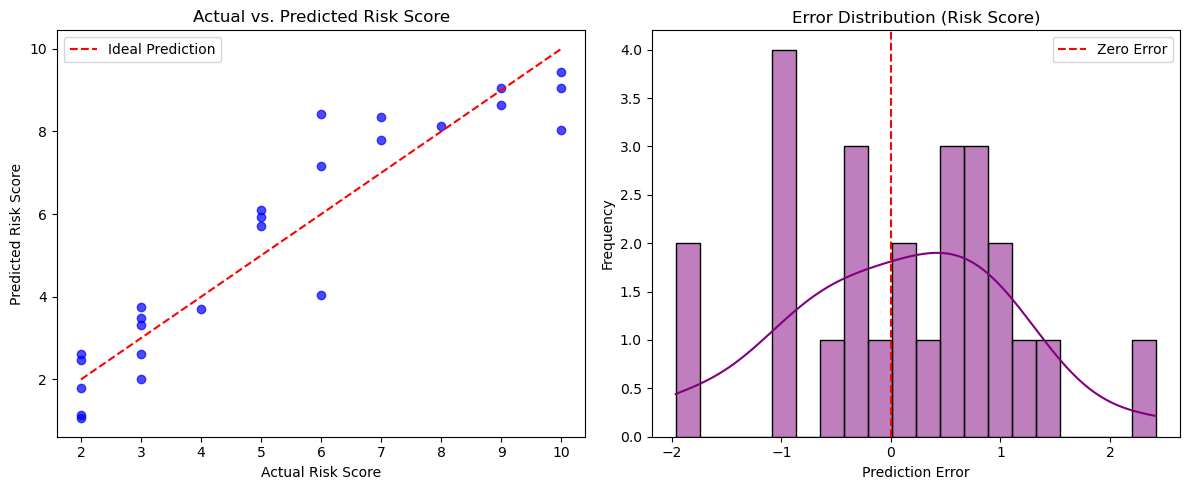

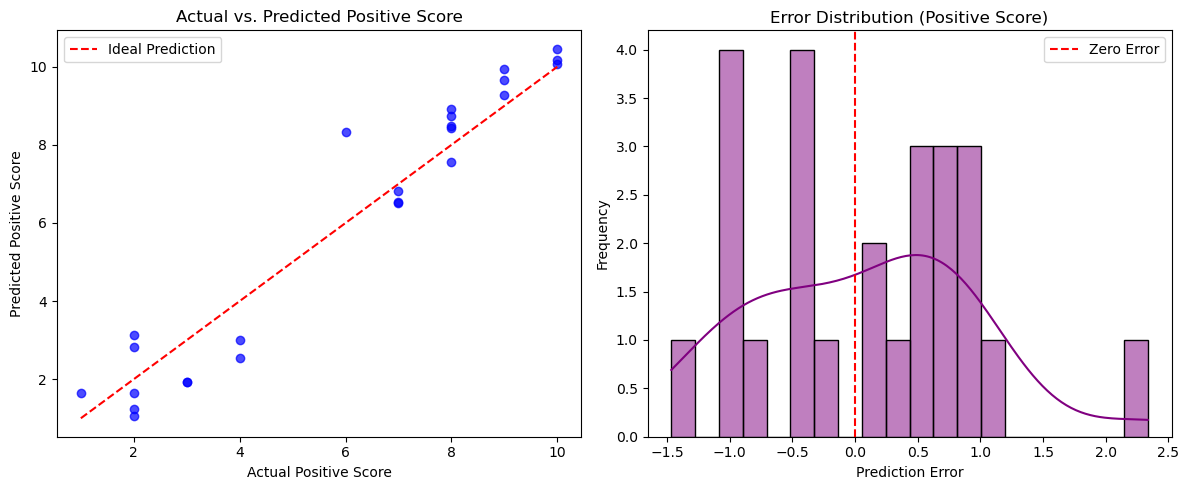

In [17]:
actual_risk, predicted_risk, actual_positive, predicted_positive = get_all_predictions(keywords, model, tokenizer)
plot_results(actual_risk, predicted_risk, "Risk Score")
plot_results(actual_positive, predicted_positive, "Positive Score")

图1：风险分数的实际值与预测值对比
左图展示了风险分数的实际值与预测值的散点图，红线表示理想预测结果；右图展示了预测误差的分布情况，紫色曲线为核密度估计，红线表示零误差线。

理想情况下，所有数据点应紧密分布在红色虚线（y=x）上。然而，实际结果显示部分点存在偏离，且点的分布越分散，模型误差越大，但整体趋势仍然保持正向。在误差分布图中，可以观察到误差围绕 0 波动，表明模型存在一定偏差，仍有优化空间。为了提升模型性能，可以考虑增加训练数据、调整优化器（如采用 MSELoss）、对数据进行归一化处理，以及增加 epoch 训练轮次以提高模型的泛化能力。

### 4.4 测试新文本

对新文本进行预测，例如"Our city is investing in renewable energy and climate adaptation."，输出预测的风险评分和正向评分，并与“可再生能源”和“气候适应”这两个关键词的预期评分进行对比。

In [95]:
new_text = "Our city is investing in renewable energy and climate adaptation."
risk_score, positive_score = predict_scores(new_text, model, tokenizer)
print(f"Text: {new_text}")
print(f"""Predicted Risk Score: {risk_score * 10:.2f} 
        (Expected: renewable energy({risk_scores['renewable energy']}),
         climate adaptation({risk_scores['climate adaptation']}))""")
print(f"""Predicted Positive Score: {positive_score * 10:.2f} 
        (Expected: renewable energy({positive_scores['renewable energy']}),
        climate adaptation({positive_scores['climate adaptation']}))""")

Text: Our city is investing in renewable energy and climate adaptation.
Predicted Risk Score: 4.62 
        (Expected: renewable energy(2),
         climate adaptation(3))
Predicted Positive Score: 7.10 
        (Expected: renewable energy(10),
        climate adaptation(8))


这表示该文本的risk score 接近 renewable energy 和 climate adaptation（8分） 的分数），positive score较高（接近 renewable energy 和 climate adaptation（8分） 的分数）。

### 4.5 近似意思测试
为了验证模型的泛化能力，我们可以测试一段不直接包含训练集关键词但意思相近的文本。例如：

In [93]:
# 测试近似意思的文本
new_text = "Our city is investing in clean energy initiatives " \
            "and disaster preparedness."
risk_score, positive_score = predict_scores(new_text, model, tokenizer)
print(f"Text: {new_text}")
print(f"""Predicted Risk Score: {risk_score * 10:.2f} 
        (Expected: renewable energy({risk_scores['renewable energy']}),
        climate adaptation({risk_scores['climate adaptation']}))""")
print(f"""Predicted Positive Score: {positive_score * 10:.2f}
        (Expected: renewable energy({positive_scores['renewable energy']}),
        climate adaptation({positive_scores['climate adaptation']}))""")

Text: Our city is investing in clean energy initiatives and disaster preparedness.
Predicted Risk Score: 5.35 
        (Expected: renewable energy(2),
        climate adaptation(3))
Predicted Positive Score: 6.67
        (Expected: renewable energy(10),
        climate adaptation(8))


这表示模型能够识别“clean energy initiatives”（近似 renewable energy）和“disaster preparedness”（近似 climate adaptation）的含义，并给出合理的分数。

## 5. 模型不足与改进建议

### 5.1 数据量不足

目前的数据集仅包含25个关键词，数据量有限，这可能导致模型出现过拟合或在新数据上的泛化能力不足。为改善这一问题，未来采取以下措施：
- 扩展训练数据集，从公开的气候变化相关文档中提取更多文本，并手动标注风险和正面分数。
- 采用数据增强技术，如同义词替换或使用生成对抗网络（GAN）生成与原始文本相似的样本。
- 增加更多与气候变化和环境政策相关的关键词，并为其手动标注风险和正面分数。例如，添加“sustainable development”和“carbon neutrality”等关键词。
- 除了关键词，加入完整的句子或段落作为训练数据，例如：“The region is suffering from severe drought due to climate change”可标注为高风险（10）和低正面（2）。
- 通过同义词替换、句子改写等技术生成更多训练数据。例如，可以将“renewable energy”替换为“clean energy”或“green energy”以丰富语料库。

### 5.2 使用领域特定模型
bert-base-uncased 是一个通用的预训练模型，适用于多种任务。未来考虑使用以下领域特定的预训练模型：
- distilbert-base-uncased：一个更轻量的模型，适用于数据量较小的任务，具有较低的计算开销。
- ClimateBERT（climatebert/distilroberta-base-climate-f）：专为气候变化任务设计，能够更好地理解与气候变化相关的术语和上下文。
- SciBERT（allenai/scibert_scivocab_uncased）：针对科学领域的模型，适合处理与环境科学相关的文本，尤其在专业术语处理上表现出色。

## 6. 结论

本文通过双维度分析（风险与积极性），全面评估气候相关关键词的影响，不仅能够识别潜在风险，还能衡量其正面作用。随后，利用自然语言处理（NLP）技术和预训练模型（如BERT）对关键词及其得分进行训练，模型评估结果表明已取得一定成效。在给定新的文本内容后，模型能够提供较为合理的预测分数。

本文提出的方法可用于气候风险评估，助力政府、企业及研究人员优化气候管理和应对策略。未来可通过结合专家评分、NLP技术以及大语言模型进一步提升风险与积极性评估的精确度和适用性。